# Utilities for Data Analysis

In [82]:
# Imports
from __future__ import division
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import json,codecs
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.size'] = 20

## Seeding 
seed = 2019
random.seed = seed
#np.random.seed = seed
tf.seed = seed

print(keras.__version__)

2.1.6-tf


# Utilities and U-Net Model

In [2]:
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           if  type(history.history[key][0]) == np.float64:
               new_hist[key] = list(map(float, history.history[key]))

    print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


# Metric and Loss
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


## Learning Rate Tuning

In [103]:
weight_path = '/Users/ChristianHaroldNunez/Desktop/colons'
lr_weight = '20_lr0001.h5'

model = UNet()
adam = keras.optimizers.Adam(lr=.0001)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef, "binary_accuracy", 'mse'])
model.load_weights(weightpath+lr_weight)
evaluation_lr = model.evaluate_generator(test_generator, steps=127)
evaluation_lr

[-0.23239551235185607,
 0.23239551235185607,
 0.8826596718134843,
 0.1119139116316095]

## Optimization Algorithm Tuning

In [41]:
weights = ['data_aug_HP2_60.h5', 'data_aug_HP2_rmsprop_60.h5', 'data_aug_HP2_sgdmom99_60.h5']
histlist = ['history_adam_60.json','history_rmsprop_60.json','history_sgdmom99_60.json']
names = ['Adam', 'RMSprop', 'SGD (beta1=.99)']
histpath = '/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/HP2/'
weightpath = '/Users/ChristianHaroldNunez/Desktop/colons/'

histories = []
for h in histlist:
    histories.append(loadHist(histpath+h))
    
histories[1].keys()

[u'loss',
 u'val_binary_accuracy',
 u'val_dice_coef',
 u'val_mean_squared_error',
 u'binary_accuracy',
 u'mean_squared_error',
 u'val_loss',
 u'dice_coef']

# Test Set

In [5]:
#weights = ['data_aug_HP4_dataaug2_adam_60.h5', 'data_aug_HP4_dataaug2_adam_60_120_120.h5', 'data_aug_HP4_dataaug2_adam_60_120_120.h5']
weights = ['data_aug_HP4_dataaug2_adam_60_120_120.h5']
histlist = ['data_aug_HP4_dataaug2_adam_60.json', 'data_aug_HP4_dataaug2_adam_60_120.json','data_aug_HP4_dataaug2_adam_60_120_120.json']
names = ['Adam', 's', 's']
histpath = '/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/HP4/'
weightpath = '/Users/ChristianHaroldNunez/Desktop/colons/'

#histories = []
#for h in histlist:
#    histories.append(loadHist(histpath+h))
    
#histories[0].keys()

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def combineGenerator(gen1, gen2):
    while True:
        yield(gen1.next()[0], gen2.next()[0])

epochs = 30
batch_size = 1
image_size = 128
data_aug_path = '/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/data_aug2/'

seed1 = 230

# Making image data for VALIDATION images
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(data_aug_path+'test/Org_upper',
    target_size=(image_size, image_size),
    batch_size=1,
    seed=seed1)

filenames = test_image_generator.filenames
nb_samples = len(filenames)

test_mask_generator = test_mask_datagen.flow_from_directory(data_aug_path+'test/GT_upper',
    target_size=(image_size, image_size),
    batch_size=1,
    seed=seed1,
    color_mode='grayscale')

test_generator = combineGenerator(test_image_generator, test_mask_generator)

Using TensorFlow backend.


Found 127 images belonging to 1 classes.
Found 127 images belonging to 1 classes.


In [7]:
model = UNet()
adam = keras.optimizers.Adam(lr=.0001)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef, "binary_accuracy", 'mse'])

# Predictions is (127,128,128,1) array holding all predictions for every test item. 
predictions = []
for weight in weights:
   print(weight)
   model.load_weights(weightpath+weight)
   predictions.append(model.predict_generator(test_generator, steps=nb_samples))

In [115]:
evals = []
for weight in weights:
    print(weight)
    model.load_weights(weightpath+weight)
    evals.append(model.evaluate_generator(test_generator, steps=127))
    
print(evals)

data_aug_HP4_dataaug2_adam_60.h5
data_aug_HP4_dataaug2_adam_60_120_120.h5
data_aug_HP4_dataaug2_adam_60_120_120.h5
[[-0.3771350041575415, 0.3771350041575415, 0.922610305425689, 0.0758484374790445], [-0.4604051164610359, 0.4604051164610359, 0.9393877645177166, 0.05928351006316623], [-0.480226320814521, 0.480226320814521, 0.941949799304872, 0.05679889194535341]]


In [ ]:
for i in range(0, len(histories)):
    print(histories[i]["dice_coef"])
    #plt.plot(histories[i]["val_dice_coef"], marker="o", label=names[i])

# Easier viewing of predictions

In [41]:
# Custom data generator -- easier to manage than ImageDataGenerator for error analysis
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
     
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "Org", id_name) + ".png"
        mask_path = os.path.join(self.path, "GT", id_name) + ".png"
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        #image = np.expand_dims(image, axis=-1)
        
        ## Reading Masks
        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(mask, axis=-1)
        #mask = np.maximum(np.zeros((self.image_size, self.image_size, 1)), mask)
                    
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [59]:
# Filenames of test images from test_generator above
test_ids = []
for i in range(0, len(filenames)):
    test_ids.append(str(filenames[i].split(".")[0].split("/")[1]))

test_ids = (np.sort(np.array(test_ids).astype(int))).astype(str)

In [60]:
train_path = "/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/"
test_gen = DataGen(test_ids, train_path, image_size=image_size, batch_size=len(test_ids))

x, y = test_gen.__getitem__(0)
print(x.shape, y.shape)

((127, 128, 128, 3), (127, 128, 128, 1))


In [61]:
model = UNet()
adam = keras.optimizers.Adam(lr=.0001)
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef, "binary_accuracy", 'mse'])
model.load_weights("data_aug_HP4_dataaug2_adam_60_120_120.h5")

In [62]:
result = model.predict(x)
#result = result > 0.5

In [93]:
smooth = 1
def dice_coef_analysis(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice_per_pic = []
for i in range(0, 127):
    dice = dice_coef_analysis(y[i], result[i])
    dice_per_pic.append(dice)
    tot = tot + dice

In [70]:
# Sort the dice coefficients into the respective sequences
a = [50, 67, 78, 103, 126, 151, 177] - 50*np.ones(7) # First list are sequence specific indices
a = a.astype(int)
# Sorting the test sets into the sequences 3-8 (6 sets):
seqs = []
for i in range(0, 6):
    seq = []
    for j in range(a[i], a[i+1]):
        seq.append(dice_per_pic[j])
    seqs.append(seq)

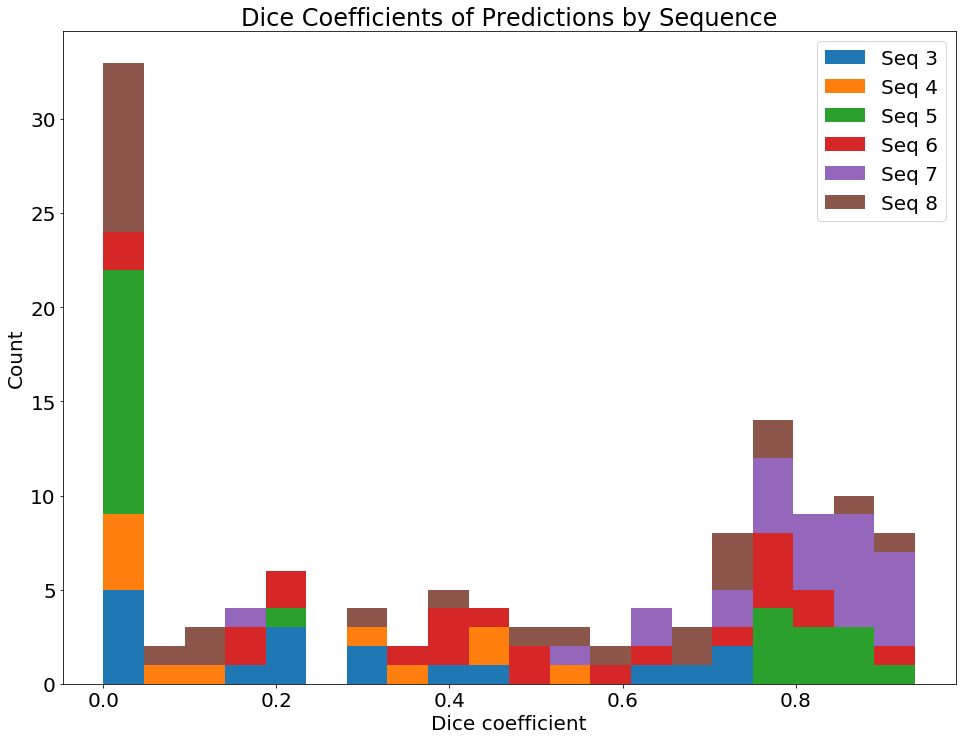

In [92]:
# Creating a stacked histogram to show how the sequences fall into the dice coefficient bins
ls = np.array(["Seq 3","Seq 4","Seq 5","Seq 6","Seq 7","Seq 8"])
plt.hist([seqs[0], seqs[1], seqs[2], seqs[3], seqs[4], seqs[5]], bins=20, label=ls, stacked=True)
plt.xlabel("Dice coefficient")
plt.ylabel("Count")
plt.title("Dice Coefficients of Predictions by Sequence")
plt.legend(fancybox=True)
plt.savefig("DiceCoefficientsbySequence.png")

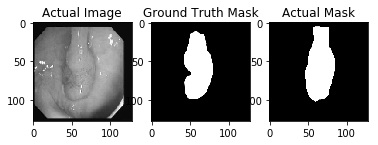

In [55]:
n = 1
fig, ax = plt.subplots(1, 3)

# Predicted Mask
ax[2].set_title("Actual Mask")
ax[2].imshow(np.reshape(y[n]*255, (image_size, image_size)), cmap="gray")

# Actual Mask'
ax[1].set_title("Ground Truth Mask")
ax[1].imshow(np.reshape(result[n]*255, (image_size, image_size)), cmap="gray")

# Actual Image
ax[0].set_title("Actual Image")
ax[0].imshow(np.reshape(x[n][:,:,0]*255, (image_size, image_size)), cmap="gray")

In [125]:
fig, ax = plt.subplots(1, 3)

# SAVE ALL TEST_IMAGE TRIPLETS FOR VIEWING
for n in range(len(test_ids)):
    ax[2].set_title("Ground Truth Mask")
    ax[2].imshow(np.reshape(y[n]*255, (image_size, image_size)), cmap="gray")

    # Actual Mask'
    ax[1].set_title("Predicted Mask")
    ax[1].imshow(np.reshape(result[n]*255, (image_size, image_size)), cmap="gray")

    # Actual Image
    ax[0].set_title("Actual Image")
    ax[0].imshow(np.reshape(x[n][:,:,0]*255, (image_size, image_size)), cmap="gray")

    plt.savefig("/Users/ChristianHaroldNunez/Desktop/colons/CVC-ClinicDB/results/saved_test_figs_TEST_data_aug_HP4_dataaug2_adam_60_120_120_id"+str(test_ids[n]))
    
plt.close()